This code implements a human-in-the-loop agent using LangChain and LangGraph. The agent is capable of answering questions by either performing calculations or conducting web searches using the Tavily search tool. The workflow is structured as a state graph: the agent first processes the user's input, then determines whether to use a tool or return an answer directly. If a tool is required, the user is asked for confirmation before proceeding with potentially expensive operations like web searches.

In [1]:
%%capture --no-stderr
!pip install langchain langchain_openai langgraph chromadb langchain_community  --q
!apt install libgraphviz-dev
!pip install pygraphviz --q

### Get the credentials

In [8]:
from google.colab import userdata
import os
os.environ["OPENAI_API_KEY"] = userdata.get('OPENAI_API_KEY')
os.environ["TAVILY_API_KEY"] = userdata.get('TAVILY')

### Set up LLM

In [9]:
from langchain_openai import ChatOpenAI

model = ChatOpenAI(temperature=0)

### Create tools
 - Multiply
 - Search

In [10]:
from langchain_core.tools import tool
from langchain_community.tools.tavily_search import TavilySearchResults

@tool
def multiply(first_number: int, second_number: int)->int:
    """Multiplies two interger together."""
    return first_number * second_number

@tool
def search(query: str):
    """perform web search on the user query"""
    tavily = TavilySearchResults(max_results=1)
    result = tavily.invoke(query)
    return result

### Combine the tools and Bind to the LLM

In [11]:
tools = [search,multiply]

In [12]:
tool_map = {tool.name: tool for tool in tools}

In [13]:
tool_map

{'search': StructuredTool(name='search', description='perform web search on the user query', args_schema=<class 'pydantic.v1.main.searchSchema'>, func=<function search at 0x7a70a0c22560>),
 'multiply': StructuredTool(name='multiply', description='Multiplies two interger together.', args_schema=<class 'pydantic.v1.main.multiplySchema'>, func=<function multiply at 0x7a70a0c224d0>)}

In [14]:
model_with_tools = model.bind_tools(tools)

### Checking the tool calling with Specific questions

In [16]:
res = model_with_tools.invoke('Search from internet and tell me who won the Champions league in 2024?')
for i in res.additional_kwargs.get("tool_calls", []):
    print(i)

{'id': 'call_I8oEu4x7e4GOXsAc7AaL3DUC', 'function': {'arguments': '{"query":"Champions league winner 2024"}', 'name': 'search'}, 'type': 'function'}


In [17]:
tool_map[i['function']['name']].invoke(i['function']['arguments'])

[{'url': 'https://en.wikipedia.org/wiki/2024_UEFA_Champions_League_final',
  'content': 'Wembley Stadium was selected by the UEFA Executive Committee during their meeting in Ljubljana, Slovenia, on 24 September 2019,[7] where the hosts for the 2021 and 2022 UEFA Champions League finals were also appointed.[8]\nOn 17 June 2020, the UEFA Executive Committee announced that due to the postponement and relocation of the 2020 final, London would instead host the 2024 final.[2]\nPre-match[edit]\nIdentity[edit]\nThe visual identity of the 2024 UEFA Champions League final was unveiled at the group stage draw in Monaco on 31 August 2023.[9]\nMatch[edit]\nDetails[edit]\nThe "home" team (for administrative purposes) will be determined by an additional draw held after the quarter-final and semi-final draws.\n Contents\n2024 UEFA Champions League final\nThe 2024 UEFA Champions League final will be the final match of the 2023–24 UEFA Champions League, the 69th season of Europe\'s premier club footbal

In [18]:
res = model_with_tools.invoke('What is 334*55')
for i in res.additional_kwargs.get("tool_calls", []):
    print(i)

{'id': 'call_y9RsvEMrOKybCcfABQ4qLmKE', 'function': {'arguments': '{"first_number":334,"second_number":55}', 'name': 'multiply'}, 'type': 'function'}


### Graph creation

In [19]:
from typing import TypedDict, Annotated, Sequence
import operator,json
from langchain_core.messages import BaseMessage


class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]

In [20]:
def invoke_model(state):
    messages = state['messages']
    question = messages[-1]   ## Fetching the user question
    return {"messages":[model_with_tools.invoke(question)]}

### Bring human in the loop

-- Bring human approval for costly tool calls or where we need validation

In [21]:
def invoke_tool(state):
    tool_calls = state['messages'][-1].additional_kwargs.get("tool_calls", [])
    tool_details = None

    for tool_call in tool_calls:
        tool_details = tool_call

    if tool_details is None:
        raise Exception("No adder input found.")

    print(f'Selected tool: {tool_details.get("function").get("name")}')

    if tool_details.get("function").get("name") == "search":
        response = input(prompt=f"[y/n] continue with expensive web search?")
        if response == "n":
            raise ValueError

    response = tool_map[tool_details['function']['name']].invoke(json.loads(tool_details.get("function").get("arguments")))
    return {"messages" : [response]}

In [22]:
from langgraph.graph import StateGraph,END

graph = StateGraph(AgentState) ### StateGraph with AgentState

graph.add_node("agent", invoke_model)

graph.add_node("tool", invoke_tool)

def router(state):
    tool_calls = state['messages'][-1].additional_kwargs.get("tool_calls", [])
    if len(tool_calls):
        return "tool"
    else:
        return "end"

graph.add_conditional_edges("agent", router, {
    "tool": "tool",
    "end": END,
})

graph.add_edge("tool", END)

graph.set_entry_point("agent")

In [23]:
app = graph.compile()

In [24]:
from IPython.display import Image, display

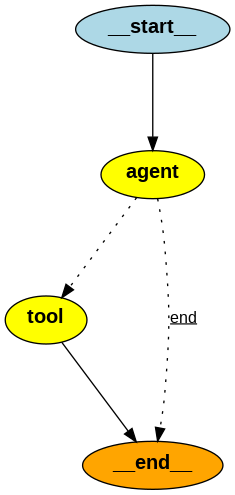

In [25]:
display(Image(app.get_graph().draw_png()))

### Testing with Questions

In [26]:
for s in app.stream({"messages": ["What is 334 * 765?"]}):
    print(list(s.values())[0])
    print("----")

{'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_kLQLwDPNjur41ah5O3PZ8K0k', 'function': {'arguments': '{"first_number": 334, "second_number": 765}', 'name': 'multiply'}, 'type': 'function'}, {'id': 'call_buakWI75WOPbfh2y66Fiab36', 'function': {'arguments': '{"first_number": 765, "second_number": 334}', 'name': 'multiply'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 53, 'prompt_tokens': 80, 'total_tokens': 133}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-8b132f62-31fc-431c-b4f0-09289502e5d0-0', tool_calls=[{'name': 'multiply', 'args': {'first_number': 334, 'second_number': 765}, 'id': 'call_kLQLwDPNjur41ah5O3PZ8K0k', 'type': 'tool_call'}, {'name': 'multiply', 'args': {'first_number': 765, 'second_number': 334}, 'id': 'call_buakWI75WOPbfh2y66Fiab36', 'type': 'tool_call'}], usage_metadata={'input_tokens': 80, 'output_tokens': 53, 'total_token

In [28]:
for s in app.stream({"messages": ["Search from internet and tell me who won the Champions league in 2024?"]}):
    print(list(s.values())[0])
    print("----")

{'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_eAs6NCppnDMk4fyz7UscrOYM', 'function': {'arguments': '{"query":"Champions league winner 2024"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 19, 'prompt_tokens': 88, 'total_tokens': 107}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-5cd98d94-8a4a-4f4c-9f51-8d3981925c47-0', tool_calls=[{'name': 'search', 'args': {'query': 'Champions league winner 2024'}, 'id': 'call_eAs6NCppnDMk4fyz7UscrOYM', 'type': 'tool_call'}], usage_metadata={'input_tokens': 88, 'output_tokens': 19, 'total_tokens': 107})]}
----
Selected tool: search
[y/n] continue with expensive web search?y
{'messages': [[{'url': 'https://www.uefa.com/uefachampionsleague/news/028e-1b07e18d875a-ba78e4b9d9fc-1000--real-madrid-win-champions-league-carvajal-and-vinicius-jun/', 'content': 'Live 01/06/2024 Champions League win

In [29]:
for s in app.stream({"messages": ["Who won the T20 Cricket world cup in 2022?"]}):
    print(list(s.values())[0])
    print("----")

{'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_VyPWAKYFxEYHLnyU6KgHSZpi', 'function': {'arguments': '{"query":"T20 Cricket World Cup 2022 winner"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 85, 'total_tokens': 106}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-401a86fc-394e-4753-8d63-fc63492f19aa-0', tool_calls=[{'name': 'search', 'args': {'query': 'T20 Cricket World Cup 2022 winner'}, 'id': 'call_VyPWAKYFxEYHLnyU6KgHSZpi', 'type': 'tool_call'}], usage_metadata={'input_tokens': 85, 'output_tokens': 21, 'total_tokens': 106})]}
----
Selected tool: search
[y/n] continue with expensive web search?y
{'messages': [[{'url': "https://en.wikipedia.org/wiki/2022_ICC_Men's_T20_World_Cup_final", 'content': "The 2022 ICC Men's T20 World Cup final was a Twenty20 International cricket match played at MCG in Melbo